## General Imports

In [1]:
import numpy as np
import scipy.stats
from scipy.stats import norm, truncnorm,binom
from scipy.io import loadmat

import pickle
import imp
import sys
import os

sys.path.append('../code/')

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline

from task_utils import action_num_to_str, state2idcs

## Save names, folders

In [3]:
save_stem='lava_lake_v3'

if not os.path.isdir('../saved_figures/'+save_stem):
    os.mkdir('../saved_figures/'+save_stem)
    
if not os.path.isdir('../saved_results/'+save_stem):
    os.mkdir('../saved_results/'+save_stem)

## Create Task

In [4]:
import task_lava_lake
imp.reload(task_lava_lake)
from task_lava_lake import Task_Lava_Lake

In [5]:
task = Task_Lava_Lake(order='C',nrows=4,ncols=7,
                      start_location=21,
                      lava_locations=[23],
                      goal_locations=[27],)

In [6]:
task.maze_w_state_labels

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [ 7.,  8.,  9., 10., 11., 12., 13.],
       [14., 15., 16., 17., 18., 19., 20.],
       [21., 22., 23., 24., 25., 26., 27.]])

In [10]:
s = 11
print('s='+str(s))
for a in range(4):
    non_zero_trans_states = np.where(task.P[s,:,a]!=0.0)[0]
    non_zero_trans_probs  = task.P[s,non_zero_trans_states,a]
    print('a='+str(action_num_to_str(a))+\
          '\t '+''.join(['s={0} p={1:.2f}  '.format(s,p) for s,p in zip(non_zero_trans_states,non_zero_trans_probs)]))
    #print(task.P[s,:,a])

s=11
a=up	 s=4 p=0.95  s=10 p=0.02  s=12 p=0.02  s=18 p=0.01  
a=down	 s=4 p=0.01  s=10 p=0.02  s=12 p=0.02  s=18 p=0.95  
a=right	 s=4 p=0.02  s=10 p=0.01  s=12 p=0.95  s=18 p=0.02  
a=left	 s=4 p=0.02  s=10 p=0.95  s=12 p=0.01  s=18 p=0.02  


In [13]:
print(task.start_location)
print(task.goal_locations)
print(task.lava_locations)
print(task.absorbing_states)
print(task.terminal_state)
print(task.reward_dicts)

21
[27]
[23]
[23, 27]
28
{27: 3, 23: -10}


## Other specifications

In [1]:
interpolation_set = np.array([0.        , 0.01      , 0.01274275, 0.01623777, 0.02069138,
                       0.02636651, 0.03359818, 0.04281332, 0.05455595, 0.06951928,
                       0.08858668, 0.11288379, 0.14384499, 0.18329807, 0.23357215,
                       0.29763514, 0.37926902, 0.48329302, 0.61584821, 0.78475997,
                       1.        ])

print(len(interpolation_set))

#alpha0_i_set = [2,8,11,14,16,18,20]
#alpha0_i_set = [2,8,9,10,11,14,16,18,20]
alpha0_i_set = [0, 2,8,11,14,16,18,20]
alpha0_set = [interpolation_set[i] for i in alpha0_i_set]
print('alpha set {}'.format(alpha0_set))

# planning horizon 
T = 60
gamma = 0.9

NameError: name 'np' is not defined

## Solve for Q-values, Generate Behavior

In [10]:
import dp
imp.reload(dp)
from dp import CVaR_DP

import mcmc_eval
imp.reload(mcmc_eval)
from mcmc_eval import run_simulation, calc_V_CVaR_MCMC

### pCVaR

In [11]:
model_name='pCVaR'

#### run

In [ ]:
results = CVaR_DP(task, T=T, alpha_set = interpolation_set, cvar_type=model_name, 
                  gamma=0.9, verbose=True,parallel=True)

#### save

In [12]:
savename= '../saved_results/'+save_stem+'/'+model_name+'_T='+str(T)+\
          '_interpset='+str(len(interpolation_set))+'.p'
print(savename)

../saved_results/lava_lake_v3/pCVaR_T=60_interpset=21.p


In [13]:
pickle.dump(results, 
            open(savename, "wb" ) )

### nCVaR

In [14]:
model_name='nCVaR'

#### Run

In [ ]:
results = CVaR_DP(task, T=T, alpha_set = interpolation_set, cvar_type=model_name, 
                  gamma=0.9, verbose=True,parallel=True)
results.pop('Xis')

#### save

In [16]:
savename= '../saved_results/'+save_stem+'/'+model_name+'_T='+str(T)+\
          '_interpset='+str(len(interpolation_set))+'.p'
print(savename)

../saved_results/lava_lake_v3/nCVaR_T=60_interpset=21.p


In [17]:
pickle.dump(results, 
            open(savename, "wb" ) )

### fCVaR

In [18]:
model_name='fCVaR'

#### Run

In [ ]:
Qs = []
for alpha0 in alpha0_set:
    print(alpha0)
    results = CVaR_DP(task, T=T, alpha0=alpha0, alpha_set = interpolation_set, cvar_type=model_name, 
                  gamma=0.9, verbose=True,parallel=True)
    Qs.append(results['Q_CVaR'])
    print()
    
results = {}
results['Q_CVaR']= np.moveaxis(np.array(Qs),0,-1)
results['Q_CVaR'].shape

#### save

In [ ]:
savename= '../saved_results/'+save_stem+'/'+model_name+'_T='+str(T)+\
          '_interpset='+str(len(interpolation_set))+'.p'
print(savename)

In [ ]:
pickle.dump(results, 
            open(savename, "wb" ) )

## Generating Behavior Function 

In [67]:
import mcmc_eval
imp.reload(mcmc_eval)
from mcmc_eval import run_simulation, calc_V_CVaR_MCMC

In [68]:
alpha0_i_set

[2, 8, 9, 10, 11, 14, 16, 18, 20]

In [69]:
def generate_behavior(model_name='pCVaR',alpha0 = 1.0,invtemp = 10,Nsims=1000):

    # get the appropriate alpha
    alpha0_i = np.where(interpolation_set==alpha0)[0][0]
    
    # load Q-function 
    savename= '../saved_results/'+save_stem+'/'+model_name+'_T='+str(T)+\
              '_interpset='+str(len(interpolation_set))+'.p'
    results = pickle.load( open(savename, "rb" ) )

    # get the q-values
    Q = results['Q_CVaR']
    if model_name=='fCVaR':
        Q = Q[:,:,:,:,np.where(np.array(alpha0_i_set)==alpha0_i)[0][0]]
    
    # calculate policy using inverse temperature 
    if invtemp=='max':
        policy = np.zeros_like(Q)
        for s in range(policy.shape[0]):
            for alph in range(policy.shape[2]):
                for t in range(policy.shape[3]):
                    maxQ_i = np.argmax(Q[s,:,alph,t])
                    policy[s,maxQ_i,alph,t] = 1.0
    else:
        policy = np.zeros_like(Q)
        denom = np.sum(np.exp(invtemp*Q[:,:,:,:]),axis=1)
        for a in range(4):
            policy[:,a,:,:] = np.exp(invtemp*Q[:,a,:,:]) / denom
        
    # generate behavior 
    if model_name=='pCVaR':
        Xis=results['Xis']
        adjust_alpha=True
    else:
        Xis=None
        adjust_alpha=False

    # run the MCMC for the changing policy 
    results_mcmc = run_simulation(task,
                                   policy,  # must be states x actions x alphas x time-steps
                                   gamma,
                                   T=T,
                                   Nsims = Nsims,
                                   s0 = task.start_location,
                                   alpha_i0= alpha0_i,
                                   alpha_set = interpolation_set,
                                   Xis=Xis,
                                   adjust_alpha=adjust_alpha)  
    
    return(results_mcmc,results)

## Plotting

In [3]:
import plotting
imp.reload(plotting)
from plotting import plot_sa

ModuleNotFoundError: No module named 'plotting'

###  fCVaR 1.0, max

In [71]:
np.random.seed(1)
model_name='fCVaR'
alpha0=1.0
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
invtemp='max'
Nsims = 1000
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
results_mcmc,_ = generate_behavior(model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)

In [72]:
import plotting
imp.reload(plotting)
from plotting import plot_sa

In [2]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

plot_sa(sa_occupancy,
        np.zeros(task.Ns-1),
        task,
        interpolation_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',min_plot=0.05,title_fs=26,start_fs=18,reward_fs=18,show_alpha0=False)

NameError: name 'plt' is not defined

###  fCVaR 0.38, max

In [74]:
np.random.seed(1)
model_name='fCVaR'
alpha0=0.37926902
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
invtemp='max'
Nsims = 1000
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
results_mcmc,_ = generate_behavior(model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)

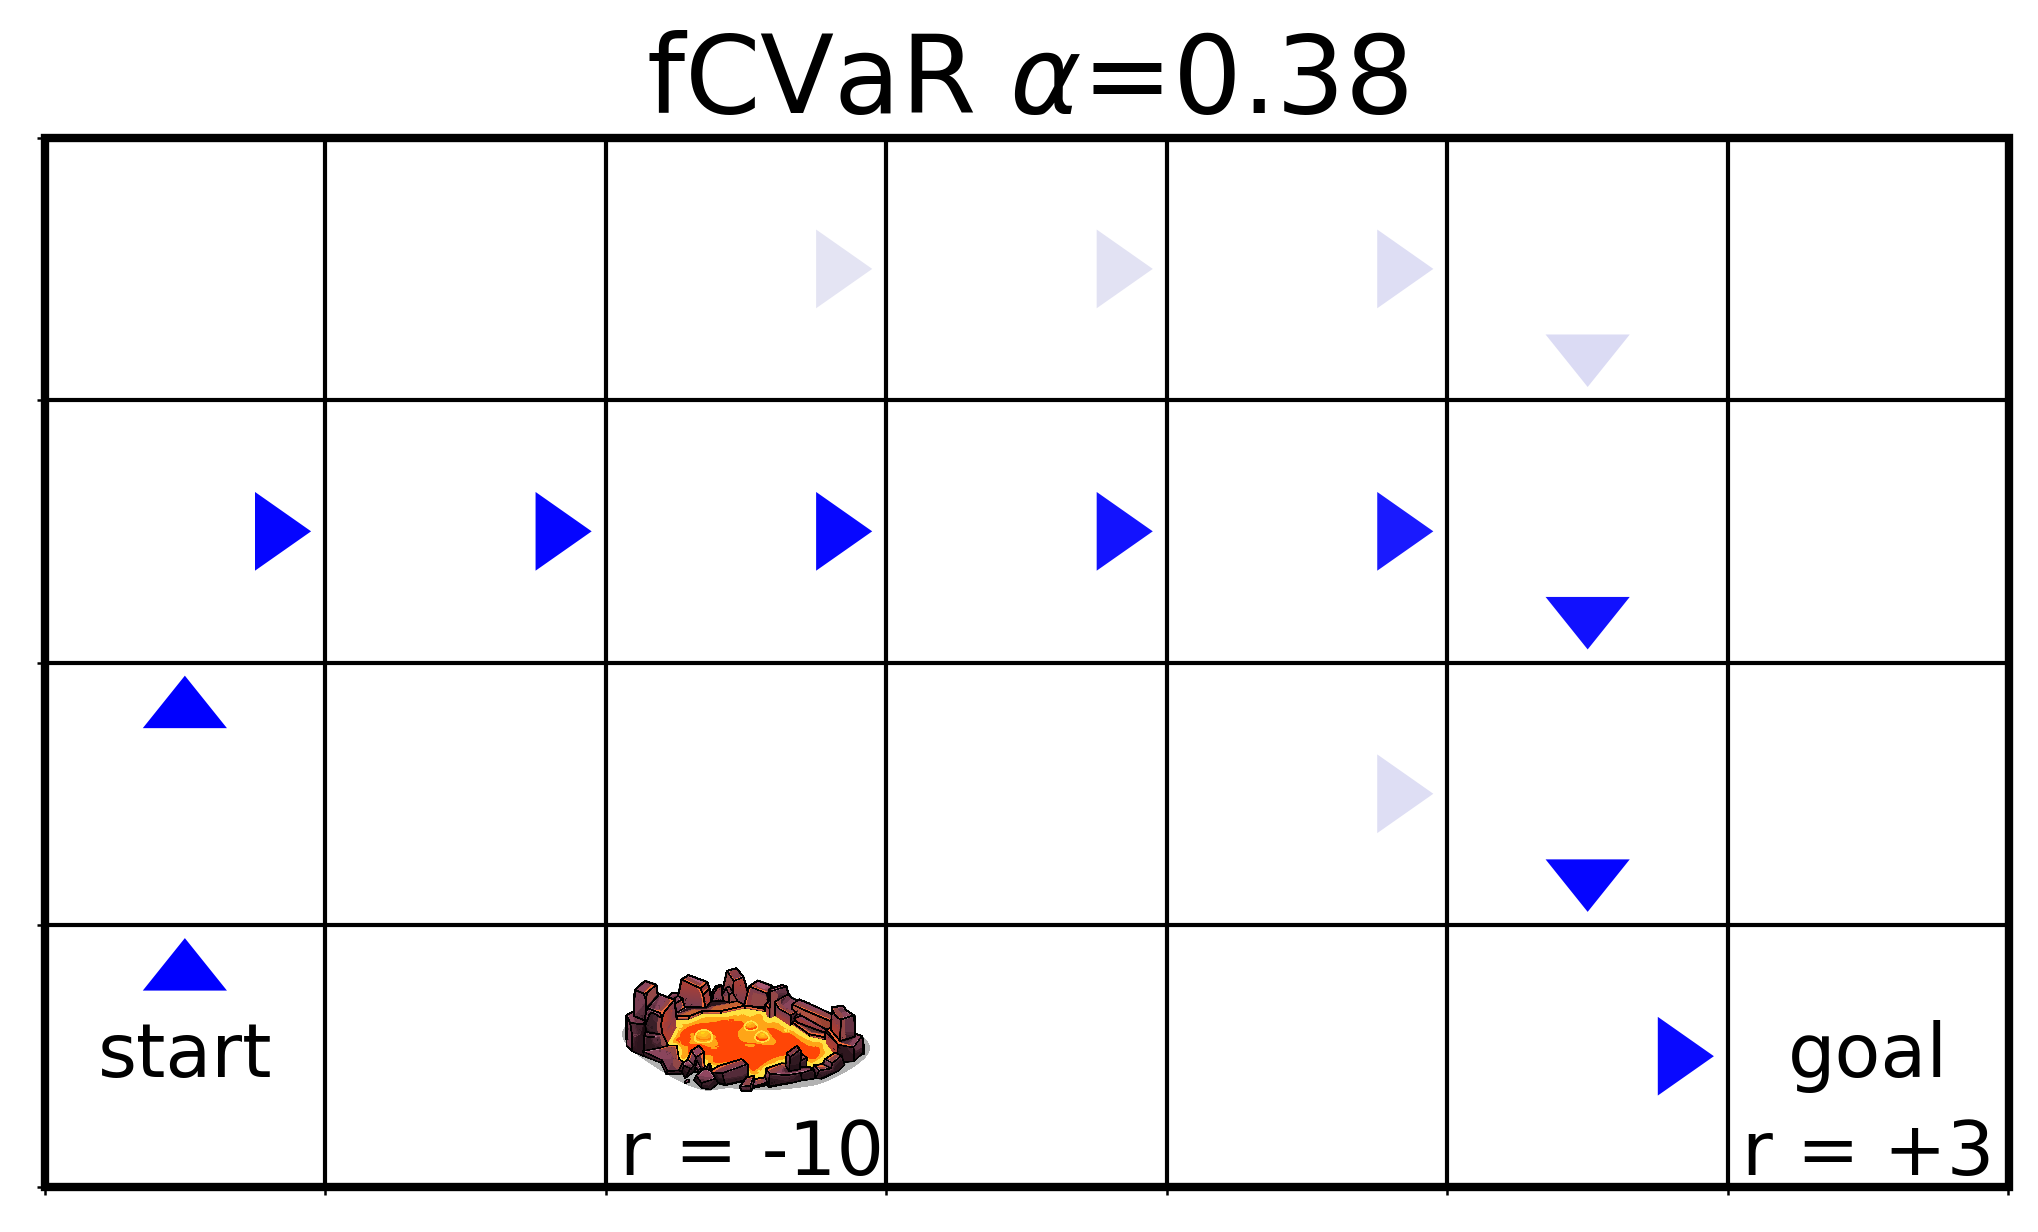

In [75]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

plot_sa(sa_occupancy,
        np.zeros(task.Ns-1),
        task,
        interpolation_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',min_plot=0.05,title_fs=26,start_fs=18,reward_fs=18,show_alpha0=False)

###  fCVaR 0.06, max

In [76]:
np.random.seed(1)
model_name='fCVaR'
alpha0=0.06951928
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
invtemp='max'
Nsims = 1000
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
results_mcmc,_ = generate_behavior(model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)

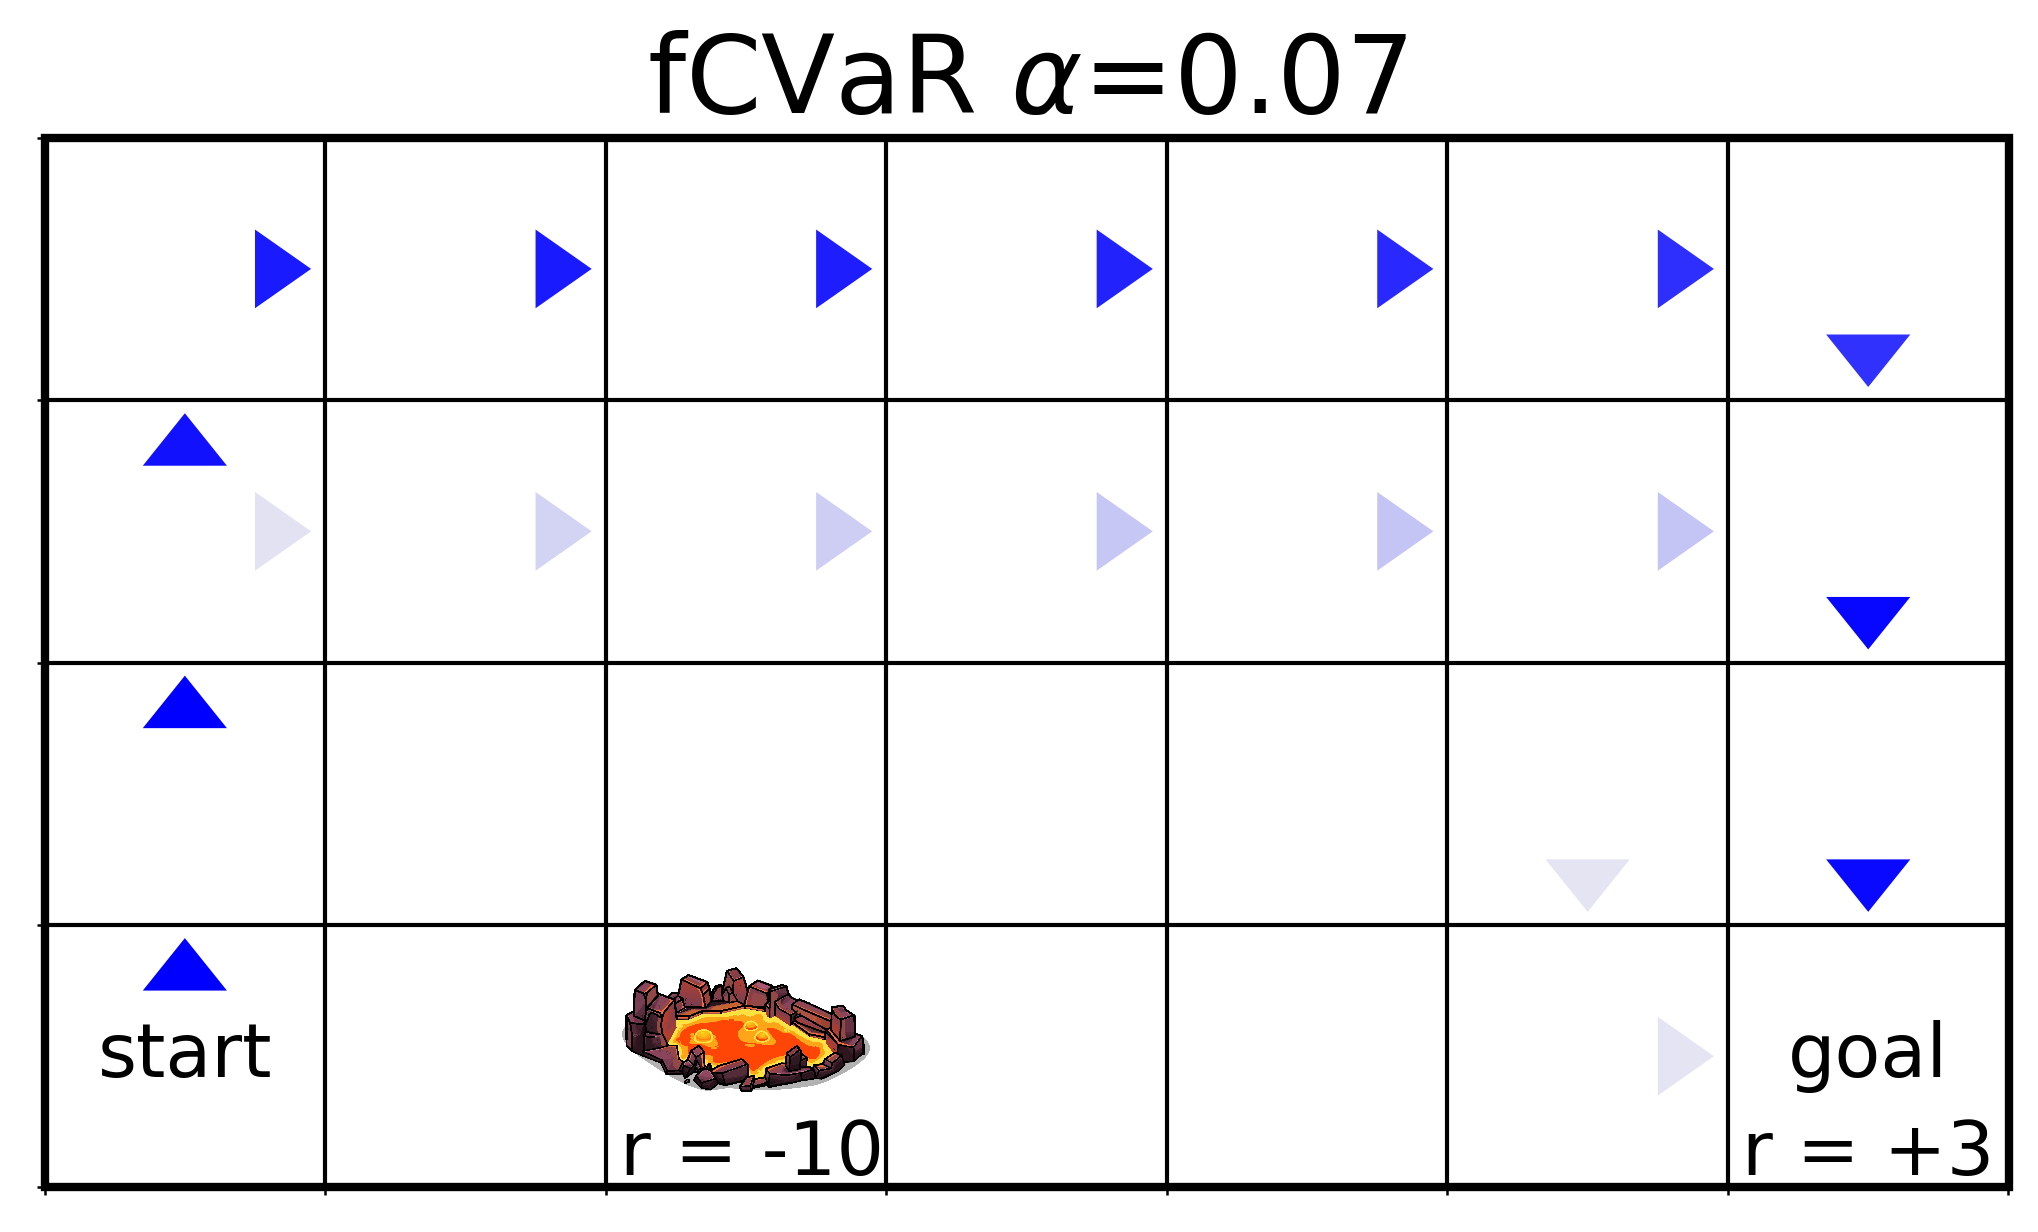

In [77]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

plot_sa(sa_occupancy,
        np.zeros(task.Ns-1),
        task,
        interpolation_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',min_plot=0.05,title_fs=26,start_fs=18,reward_fs=18,show_alpha0=False)

###  nCVaR 0.11, max

In [78]:
np.random.seed(1)
model_name='nCVaR'
alpha0=0.11288379
Nsims=1000
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
invtemp='max'
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
results_mcmc,_ = generate_behavior(model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)

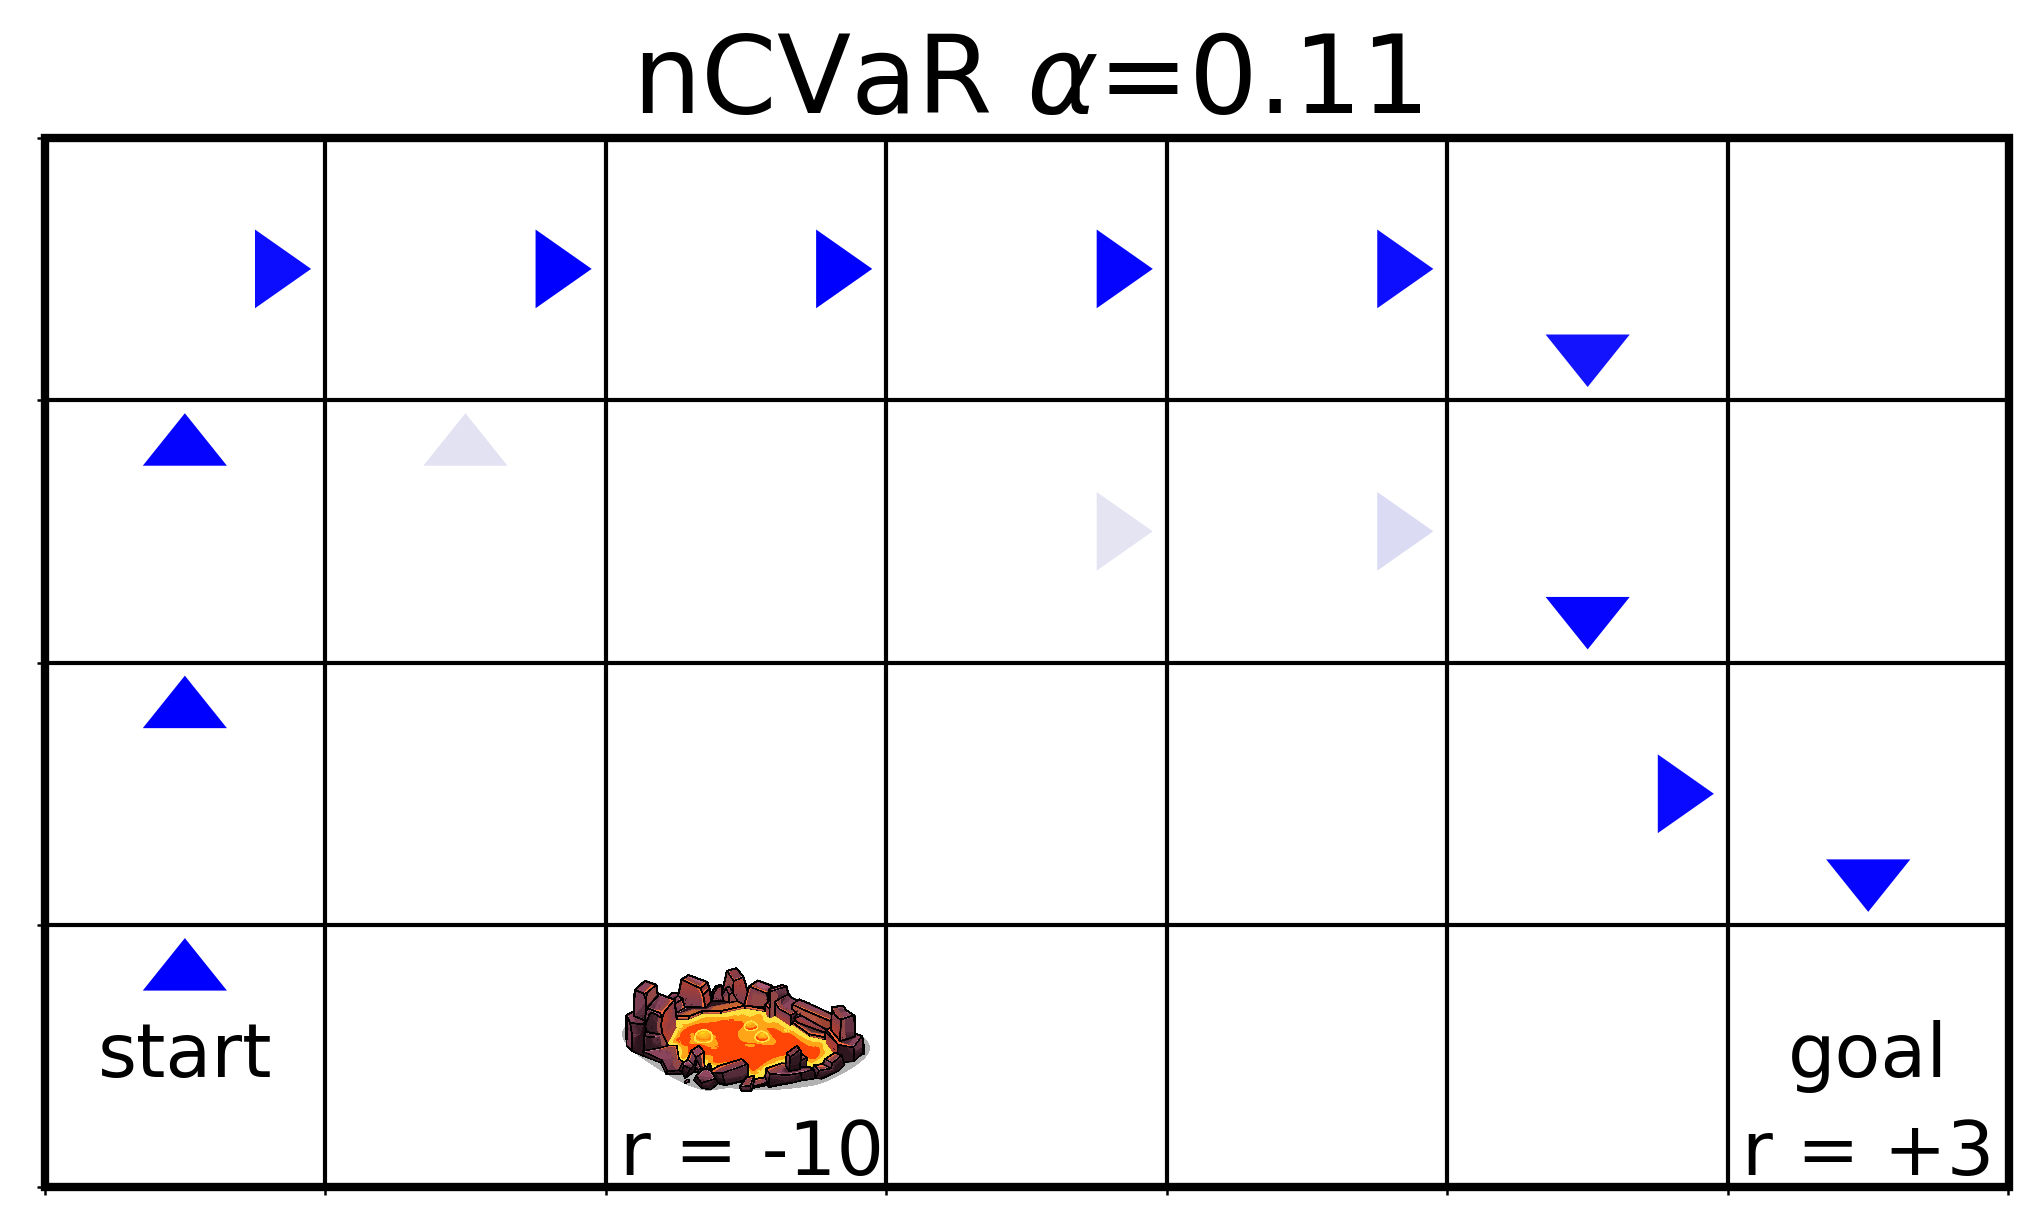

In [79]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

plot_sa(sa_occupancy,
        np.zeros(task.Ns-1),
        task,
        interpolation_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',min_plot=0.05,title_fs=26,start_fs=18,reward_fs=18,show_alpha0=False)

###  fCVaR 0.11, max

In [80]:
np.random.seed(1)
model_name='fCVaR'
alpha0=0.11288379
Nsims=1000
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
invtemp='max'
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
results_mcmc,_ = generate_behavior(model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)

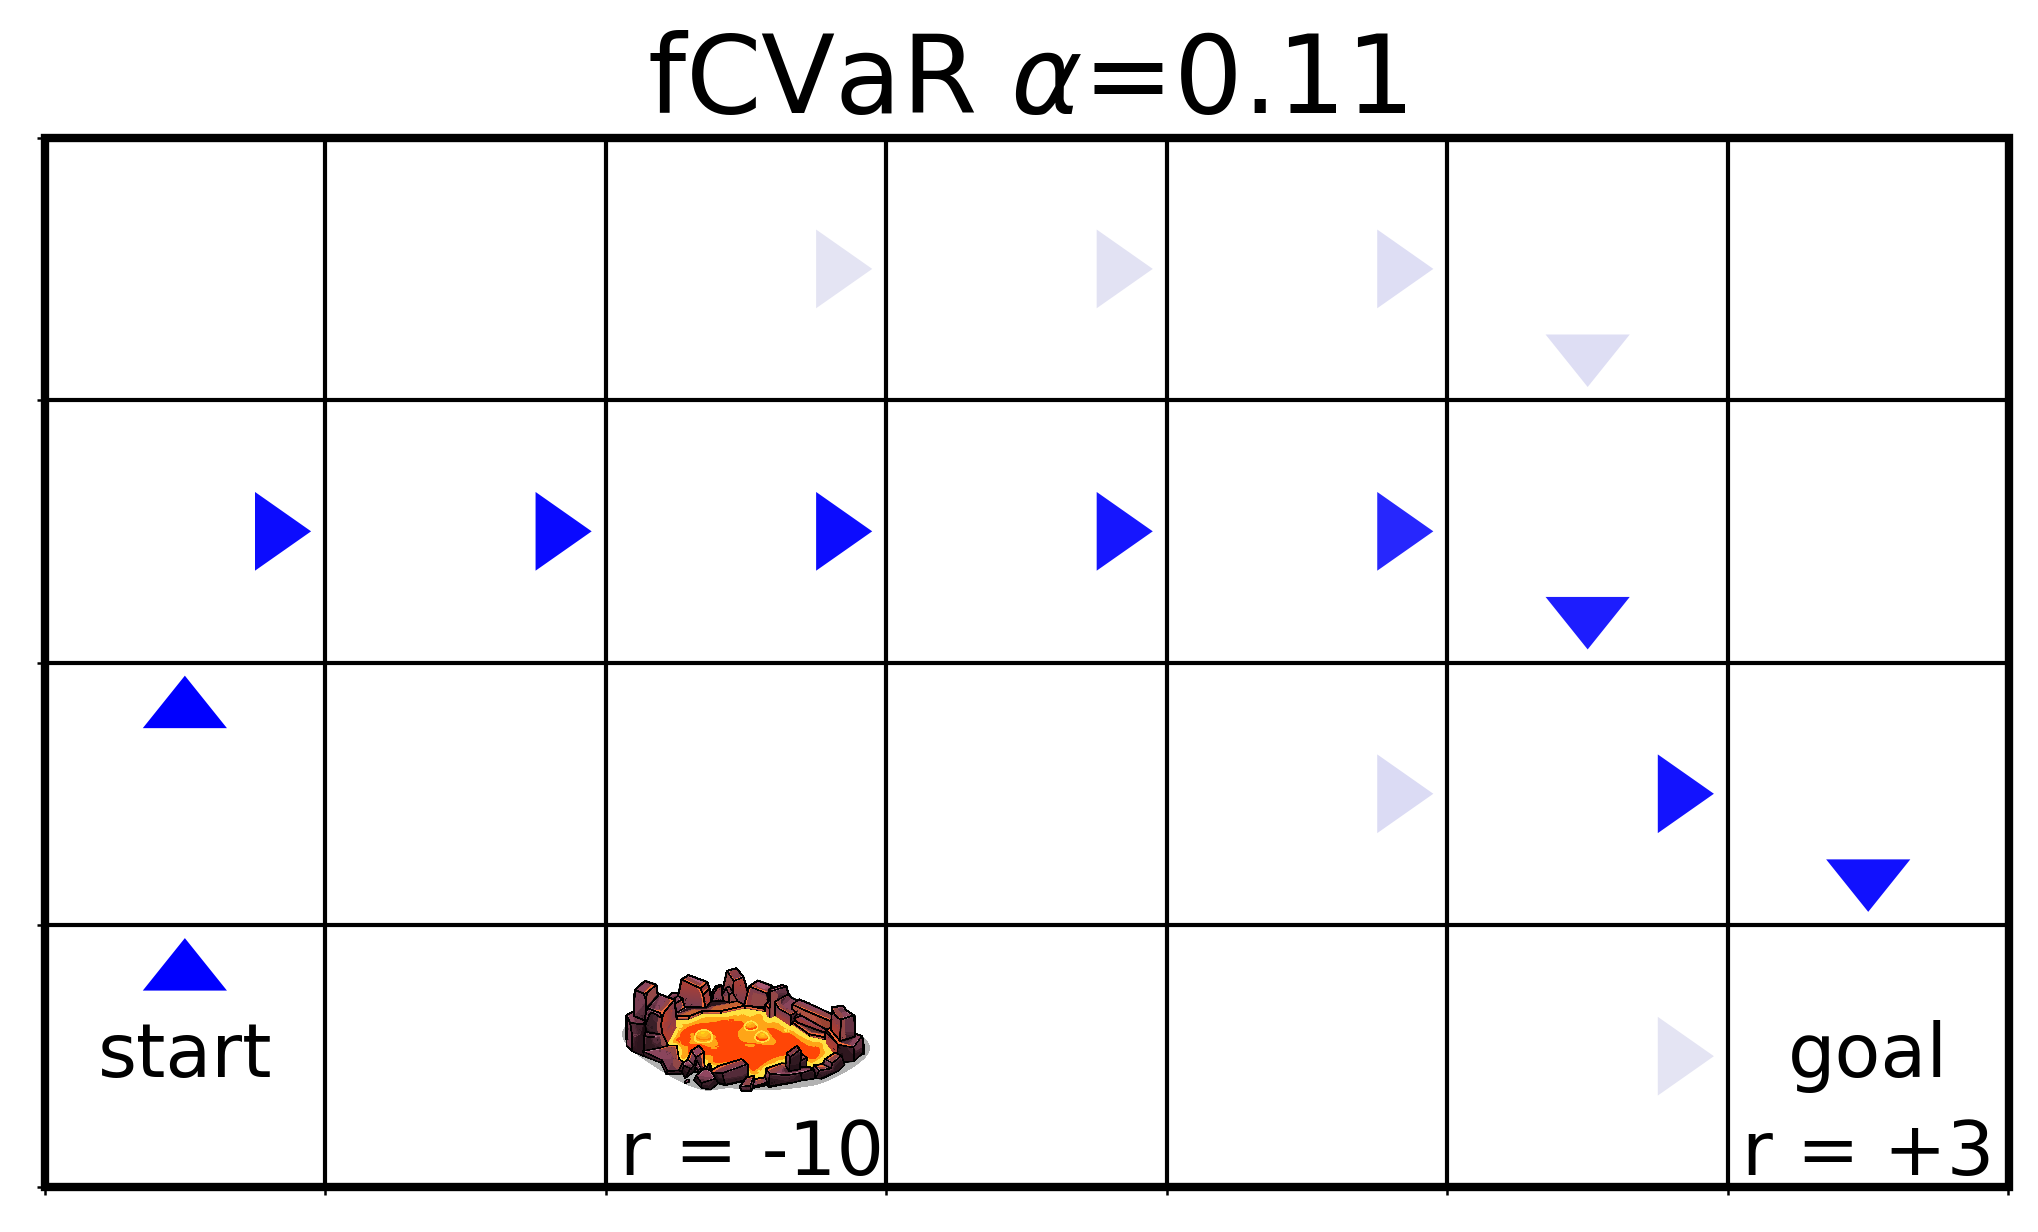

In [81]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = results_mcmc['sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

plot_sa(sa_occupancy,
        np.zeros(task.Ns-1),
        task,
        interpolation_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',min_plot=0.05,title_fs=26,start_fs=18,reward_fs=18,show_alpha0=False)

###  pCVaR 0.11, max

In [88]:
import plotting
imp.reload(plotting)
from plotting import plot_sa

In [89]:
np.random.seed(1)
model_name='pCVaR'
alpha0=0.11288379
Nsims=1000
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
invtemp='max'
alpha0_i = np.where(interpolation_set==alpha0)[0][0]
results_mcmc,_ = generate_behavior(model_name=model_name,
                                   alpha0 = alpha0,
                                   invtemp = invtemp,
                                   Nsims=Nsims)

In [90]:
med_alpha_per_state = []
mean_alpha_per_state = []
for s in range(task.Ns):
    med_alpha_per_state.append(np.median(results_mcmc['alphas'][results_mcmc['states']==s]))
    mean_alpha_per_state.append(np.mean(results_mcmc['alphas'][results_mcmc['states']==s]))
med_alpha_per_state=np.array(med_alpha_per_state)
mean_alpha_per_state=np.array(mean_alpha_per_state)

In [91]:
max_sa_occupancy = np.max(sa_occupancy,axis=1)#[0:(task.Ns-1)]#.reshape(task.maze.shape)

med_alpha_per_state_masked = med_alpha_per_state[0:(task.Ns-1)].copy()
med_alpha_per_state_masked[max_sa_occupancy<=0.05]=0.0

In [92]:
import plotting
imp.reload(plotting)
from plotting import plot_sa

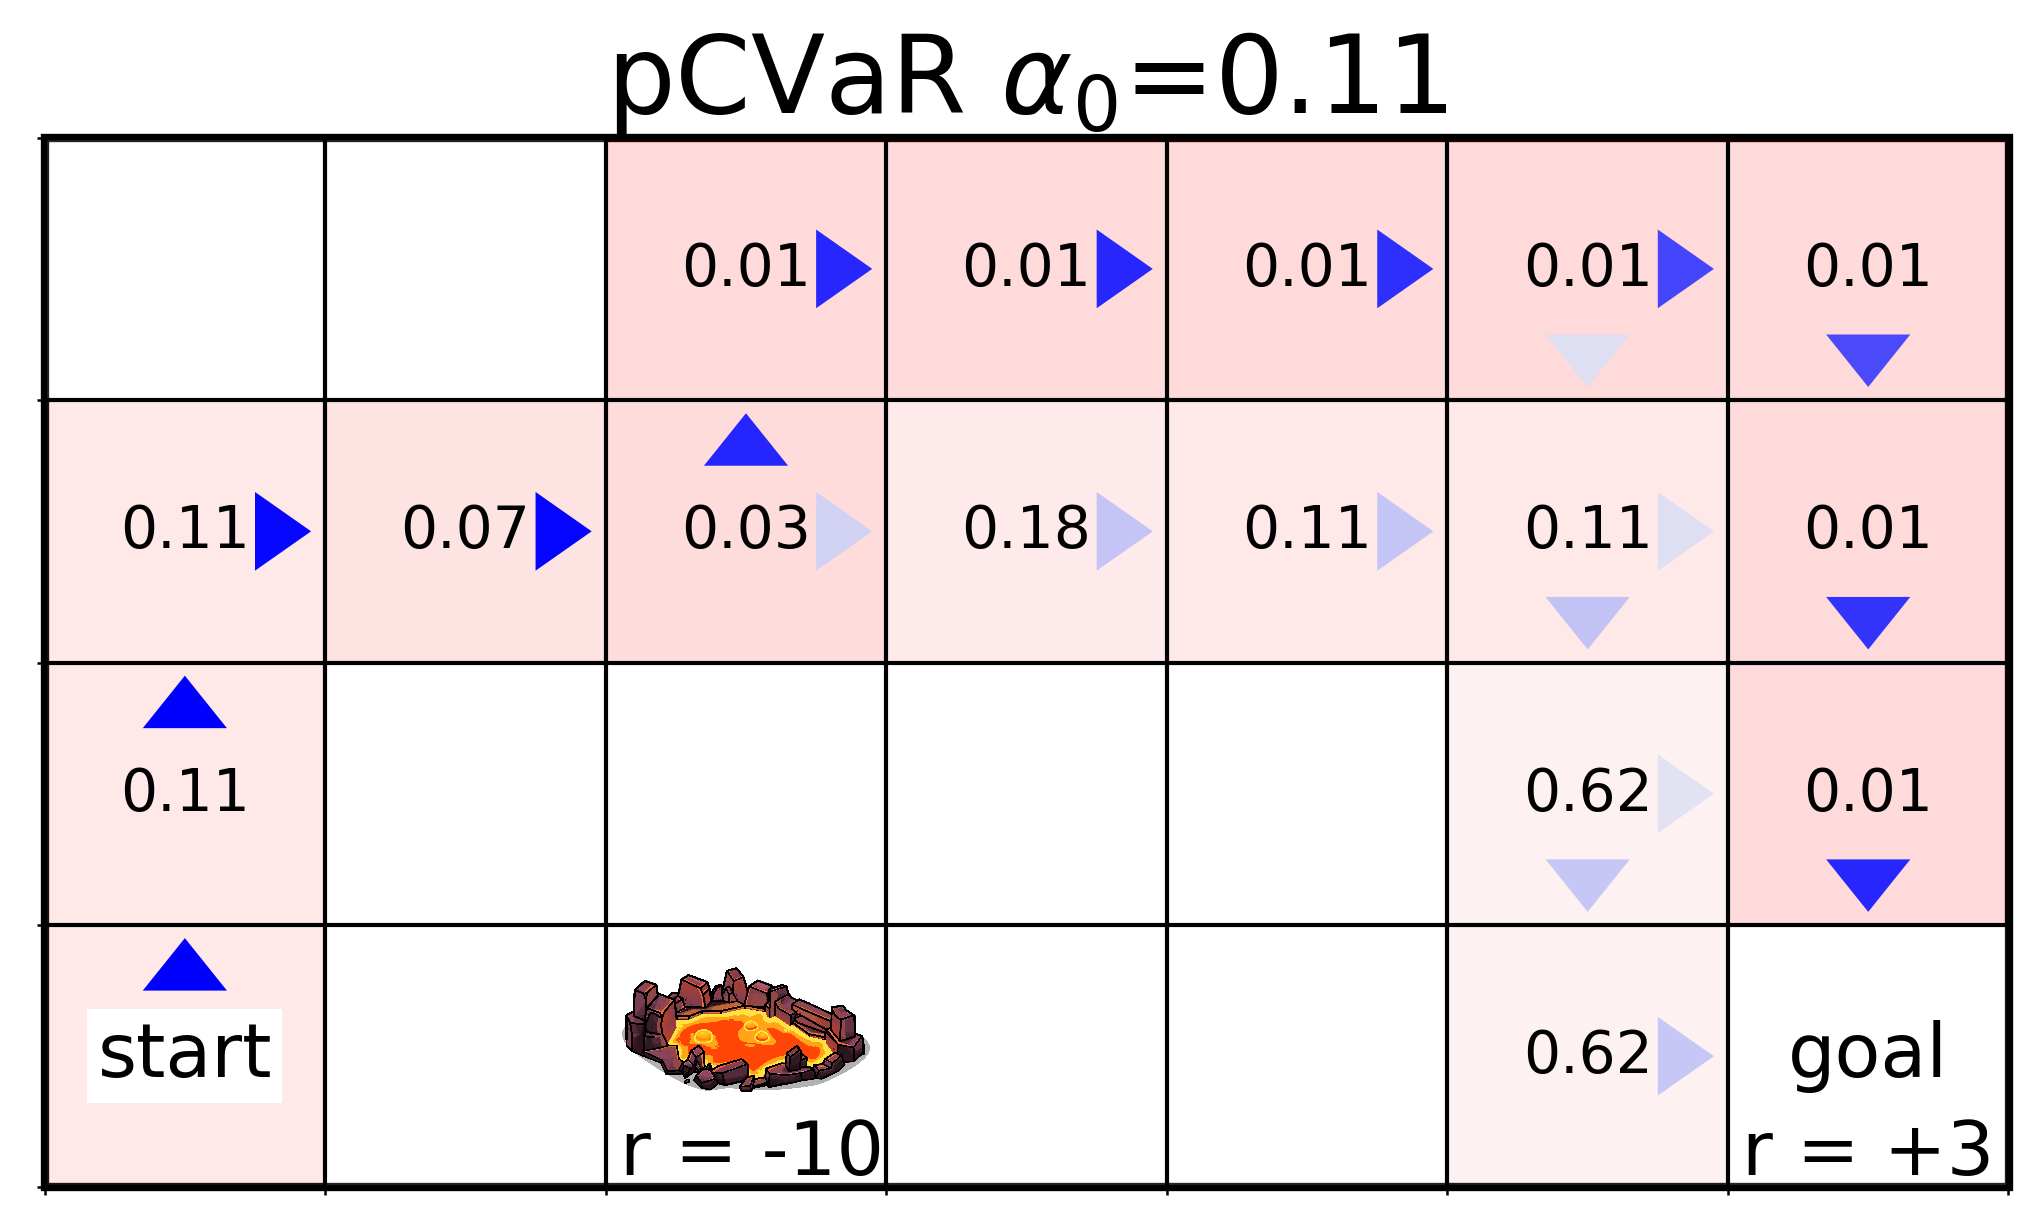

In [94]:
fig,ax = plt.subplots(1,1,figsize=(7,4),dpi=300)

sa_occupancy = results_mcmc['first_sa_occup'].sum(axis=0)[0:-1,:]
#sa_occupancy = results_mcmc['sa_occup'].sum(axis=0)[0:-1,:]
sa_occupancy = sa_occupancy/Nsims

plot_sa(sa_occupancy,
        med_alpha_per_state_masked, #np.round(med_alpha_per_state[0:(task.Ns-1)],2),
        task,
        interpolation_set,
        alpha0_i,
        model_name=model_name,
        q_or_pi='pi',
        fig=fig,
        ax=ax,
        finish=True,
        pi_color='blue',
        min_plot=0.05,title_fs=26,start_fs=18,reward_fs=18,value_fs=14,show_alpha0=True)